In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from scipy.stats import spearmanr
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
concentrations = {
    'c1': 10e-6,
    'c2': 3e-6,
    'c3': 1e-6,
}
concentrations.update({'LC': min(concentrations.values()) / 1e3})
concentrations_log10 = {k: np.log10(v) for k, v in concentrations.items()}
concentrations_log10

{'c1': -5.0, 'c2': -5.522878745280337, 'c3': -6.0, 'LC': -9.0}

In [3]:
compound = 'TI26'
assay = 'TNF'
bname = '../../resources/cell-based-assays/Tina-email-2023-08-31/'
fpath = bname + compound + '_' + assay + '.txt'
data = pd.read_csv(fpath, sep='\t')
data

,VC,c1,c2,c3,RI,LC
0,0.917858,0.755247,9.443050,36.121420,1.403177,13.312150
1,1.303890,7.497930,11.304590,1.577535,0.268734,2.062547
2,0.706698,0.442091,12.486180,28.991770,0.276541,1.752594
3,0.771455,0.958683,4.763406,17.613260,0.812029,1.262600
4,0.394515,0.909701,4.902034,1.180168,0.191152,0.593902
5,0.489854,1.303890,3.428685,8.875549,1.594178,51.612920


In [4]:
df = data[concentrations.keys()].stack().to_frame('readout')
df['conc'] = [concentrations[c] for c in df.index.get_level_values(1)]
df['conc_log10'] = [concentrations_log10[c] for c in df.index.get_level_values(1)]
df

readout          conc  conc_log10
0 c1   0.755247  1.000000e-05   -5.000000
  c2   9.443050  3.000000e-06   -5.522879
  c3  36.121420  1.000000e-06   -6.000000
  LC  13.312150  1.000000e-09   -9.000000
1 c1   7.497930  1.000000e-05   -5.000000
  c2  11.304590  3.000000e-06   -5.522879
  c3   1.577535  1.000000e-06   -6.000000
  LC   2.062547  1.000000e-09   -9.000000
2 c1   0.442091  1.000000e-05   -5.000000
  c2  12.486180  3.000000e-06   -5.522879
  c3  28.991770  1.000000e-06   -6.000000
  LC   1.752594  1.000000e-09   -9.000000
3 c1   0.958683  1.000000e-05   -5.000000
  c2   4.763406  3.000000e-06   -5.522879
  c3  17.613260  1.000000e-06   -6.000000
  LC   1.262600  1.000000e-09   -9.000000
4 c1   0.909701  1.000000e-05   -5.000000
  c2   4.902034  3.000000e-06   -5.522879
  c3   1.180168  1.000000e-06   -6.000000
  LC   0.593902  1.000000e-09   -9.000000
5 c1   1.303890  1.000000e-05   -5.000000
  c2   3.428685  3.000000e-06   -5.522879
  c3   8.875549  1.000000e-06   -6.000000
  LC  51.612920  1.000000e-09   -9.000000

## Spearman correlation: conc vs readout

In [5]:
spearmanr(df.drop('conc', axis=1).drop('LC', axis=0, level=1))

SignificanceResult(statistic=-0.6295115802917071, pvalue=0.005119517643890959)

In [6]:
x_obs = df['conc_log10'].values
y_obs = df['readout'].values
n_chains = 4
my_random_seed = 1949

def sample_linear_1(y_obs=y_obs, x_obs=x_obs):
    mymodel = pm.Model()
    with mymodel:
        σ = pm.HalfStudentT("σ", 20, 100)
        β_0 = pm.Normal("β_0", mu=0, sigma=100)
        β_1 = pm.Normal("β_1", mu=0, sigma=50)
        μ = pm.Deterministic("μ", β_0 + β_1 * x_obs)
        y = pm.Normal("y", mu=μ, sigma=σ, observed=y_obs)
        mcmc = pm.sample(return_inferencedata=True, random_seed=[my_random_seed] * n_chains)
        return((mcmc, mymodel))

def sample_sigmoid_1(y_obs=y_obs, x_obs=x_obs):
    mymodel = pm.Model()
    with mymodel:
        σ = pm.HalfStudentT("σ", nu=20, sigma=100)
        y_min = pm.Normal('y_min', 5, 5)
        y_max = pm.Normal('y_max', 20, 20)
        Δ_pct = pm.Deterministic('Δ_pct', (y_min - y_max) / y_max * 100)
        k = pm.HalfStudentT("k", nu=1, sigma=1)
        EC_50 = pm.Normal('EC_50', -5.5, 0.25)
        μ = pm.Deterministic("μ", y_min + (y_max - y_min) / (1 + np.exp(k * (x_obs - EC_50))))
        y = pm.Normal("y", mu=μ, sigma=σ, observed=y_obs)
        mcmc = pm.sample(return_inferencedata=True, random_seed=[my_random_seed] * n_chains)
        return((mcmc, mymodel))

my_models = {
    'linear 1': sample_linear_1,
    'sigmoid 1': sample_sigmoid_1,
}

In [7]:
#mcmc = dict()
#mcmc['linear_A'] = sample_m_linear_A()
idata = {name: model(y_obs, x_obs) for name, model in my_models.items()}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, y_min, y_max, k, EC_50]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


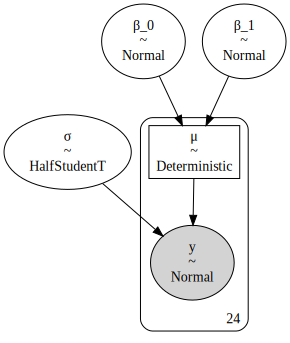

In [8]:
pm.model_to_graphviz(idata['linear 1'][1])

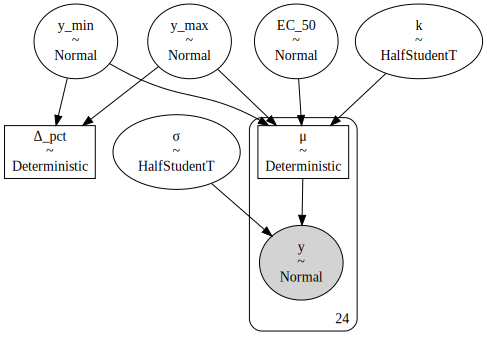

In [9]:
pm.model_to_graphviz(idata['sigmoid 1'][1])

In [10]:
prior_linear_1 = pm.sample_prior_predictive(model=idata['linear 1'][1])
prior_linear_1

Sampling: [y, β_0, β_1, σ]


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

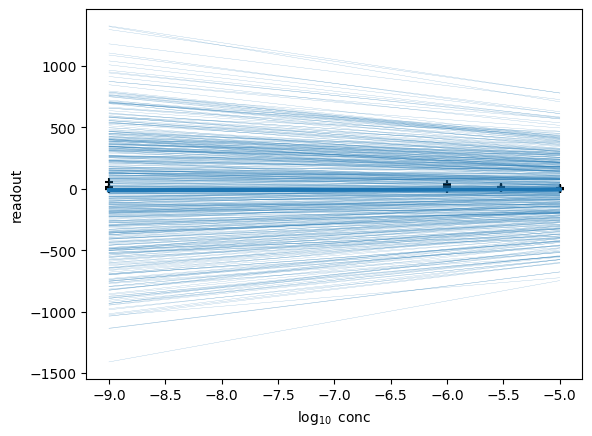

In [12]:
def plot_data(ax, data=df):
    xx = np.linspace(df.conc_log10.min(), df.conc_log10.max(), 100)
    ax.scatter(x='conc_log10', y='readout', data=df, marker='+', color='k')
    ax.set_xlabel(r'$\log_{10}$ conc')
    ax.set_ylabel(r'readout')
    return(ax)

def plot_sampled_curves_linear_1(ax, data=prior_linear_1.prior, color='C0', alpha=0.5):
    xx = np.linspace(df.conc_log10.min(), df.conc_log10.max(), 100)
    for i in range(data.dims['draw']):
        yy = data['β_0'][0][i].to_numpy() + data['β_1'][0][i].to_numpy() * xx
        ax.plot(xx, yy, linewidth=0.2, color=color, alpha=alpha)
    β_0_mean = data.mean().to_dict()['data_vars']['β_0']['data']
    β_1_mean = data.mean().to_dict()['data_vars']['β_1']['data']
    y_linear_1_mean = β_0_mean + β_1_mean * xx
    ax.plot(xx, y_linear_1_mean, color=color, linewidth=3, label='linear 1')
    return(ax)

fig, ax = plt.subplots()
ax = plot_data(ax)
ax = plot_sampled_curves_linear_1(ax, data=prior_linear_1.prior)

In [13]:
prior_sigmoid_1 = pm.sample_prior_predictive(model=idata['sigmoid 1'][1])

Sampling: [EC_50, k, y, y_max, y_min, σ]


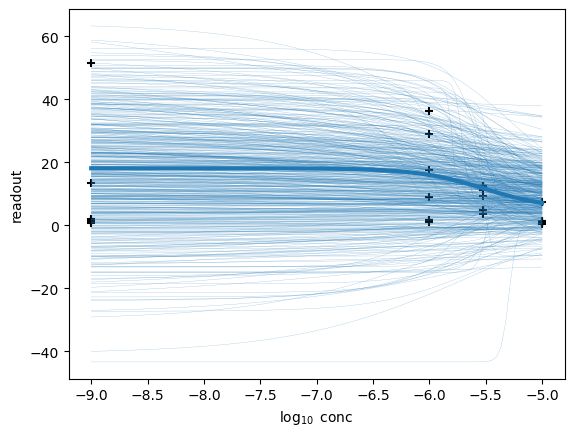

In [14]:
def plot_sampled_curves_sigmoid_1(ax, data=prior_sigmoid_1.prior, color='C0', alpha=0.5):
    xx = np.linspace(df.conc_log10.min(), df.conc_log10.max(), 100)
    for i in range(data.dims['draw']):
        EC_50 = data['EC_50'][0][i].to_numpy()
        k = data['k'][0][i].to_numpy()
        y_max = data['y_max'][0][i].to_numpy()
        y_min = data['y_min'][0][i].to_numpy()
        yy = y_min + (y_max - y_min) / (1 + np.exp(k * (xx - EC_50)))
        ax.plot(xx, yy, linewidth=0.2, color=color, alpha=alpha)
    EC_50_mean = data.mean().to_dict()['data_vars']['EC_50']['data']
    k_mean = data.mean().to_dict()['data_vars']['k']['data']
    y_max_mean = data.mean().to_dict()['data_vars']['y_max']['data']
    y_min_mean = data.mean().to_dict()['data_vars']['y_min']['data']
    σ_mean = data.mean().to_dict()['data_vars']['σ']['data']
    y_sigmoid_1_mean = y_min_mean + (y_max_mean - y_min_mean) / (1 + np.exp(k_mean * (xx - EC_50_mean)))
    ax.plot(xx, y_sigmoid_1_mean, color=color, linewidth=3, label='sigmoid 1')
    return(ax)

fig, ax = plt.subplots()
ax = plot_data(ax)
ax = plot_sampled_curves_sigmoid_1(ax, data=prior_sigmoid_1.prior)

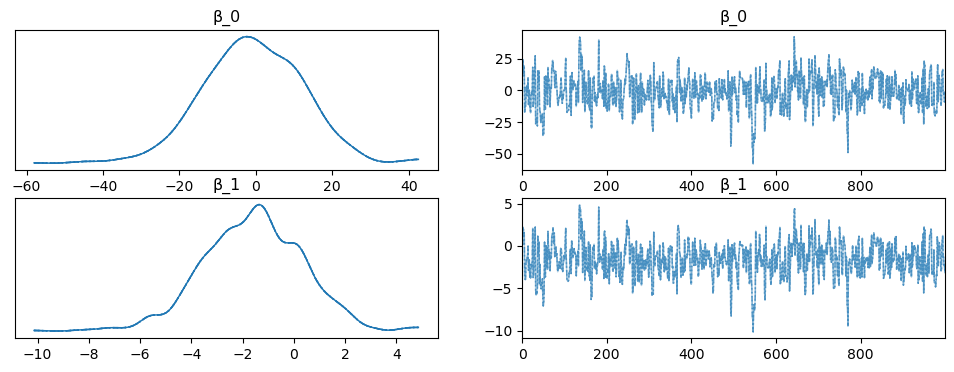

In [15]:
var_names = ['β_0', 'β_1']
#var_names = ['y_min', 'y_max', 'k', 'EC_50', 'Δ_pct']
sel_mod = 'linear 1'
#sel_mod = 'sigmoid 1'
ax = az.plot_trace(idata[sel_mod][0], var_names=var_names)
#ax[-1][0].set_xlim(-200, 200)

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

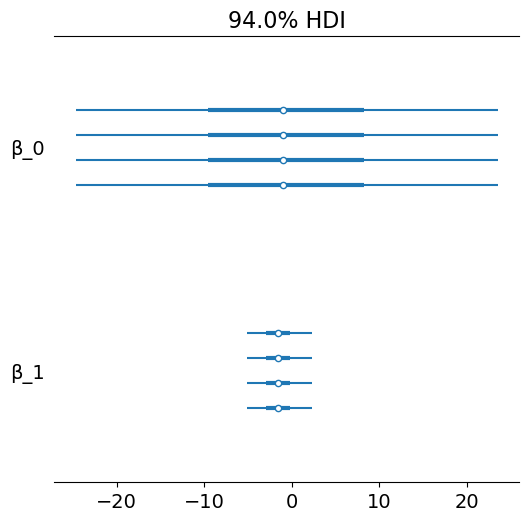

In [16]:
az.plot_forest(idata[sel_mod][0], var_names=var_names)

In [17]:
az.summary(idata[sel_mod][0], var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_0,-1.041,13.248,-24.724,23.630,0.405,0.302,1112.0,1203.0,1.0
β_1,-1.631,2.018,-5.153,2.291,0.061,0.045,1137.0,1108.0,1.0


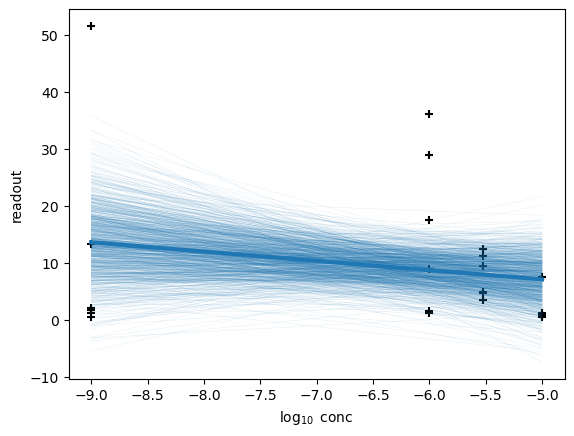

In [18]:
fig, ax = plt.subplots()
ax = plot_data(ax)
ax = plot_sampled_curves_linear_1(ax, data=idata['linear 1'][0].posterior, alpha=0.2)

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_69799/4240850149.py:8: RuntimeWarning: overflow encountered in exp
  yy = y_min + (y_max - y_min) / (1 + np.exp(k * (xx - EC_50)))


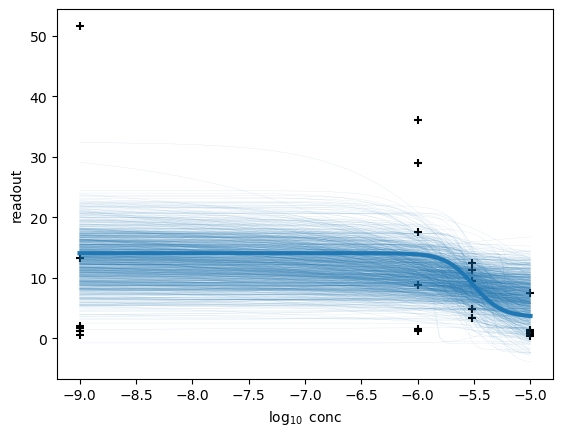

In [19]:
fig, ax = plt.subplots()
ax = plot_data(ax)
ax = plot_sampled_curves_sigmoid_1(ax, data=idata['sigmoid 1'][0].posterior, alpha=0.2)

In [20]:
%connect_info

{
  "shell_port": 60378,
  "iopub_port": 60379,
  "stdin_port": 60380,
  "control_port": 60382,
  "hb_port": 60381,
  "ip": "127.0.0.1",
  "key": "7e6e41dc-376e01d65dbc837a4b9d8adb",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-57cb3bb3-f7e6-4a41-9f4b-f2db9b08639b.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
